## _Training: DNN Tracking on STT (Hit Triplets)_

Waleed's TrackML like solution. Its similar to TrackML second solution (difference is in feature columns, prob table, hits in adjacent layers).

- Dense Network (DNN)
- Hit Triplet Probabilities
- Cluster Hits into Tracks

Inputs (features) and Targets (Labels) for this method are;

$$X = (h_{i}, h_{j}, h_{k})$$
$$y = 1 / 0$$

Where $h_{i}$ = __*(hit_id, x, y, skewed, layer_id, sector_id, isochrone_radius, particle_id)*__ etc. We can add more information in a hit.

Note
- Train[:,:-1] all columns except last one (-1), Train[:,-1] only last column (-1)

### _For validation accuracy $\ge$ training accuracy_

- [stackoverflow.com](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)
- [keras.io](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)
- [cs231n.github.io](http://cs231n.github.io/neural-networks-3/#sanitycheck)

### _Network Performance_

- We would expect many more epochs needed to minimize the error or we may just have too many hidden nodes.
- If an epoch consists of $11 \times 10^6$ examples, then most of the update work might already be done within the $1^{st}$ epoch. In that case, a **loss graph** over **training example number** rather than over epochs might be more instructive to see initial training behaviour.
- Did you use [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) to avoid overtraining? **Issue:** it might not use whole data set. **Solution:** use epoch number as hyeprparameter.
- Hyperparameter Tuning (**GridSearchCV**)
- Maybe some data preprocessing might help the network to ease the task of implicit data preprocessing. In other words, you might want to apply a standardizing [(log-)z-score transformation](https://en.wikipedia.org/wiki/Standard_score) before training.

In [1]:
import os
import glob
import math
import random

In [9]:
import pickle
import numpy as np
import pandas as pd
import dask.dataframe as dd
# from tqdm import tnrange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [10]:
from init_models import init_model, init_model_dnn
from utils import dask_events, load_events, preprocess, prepare_train_set, prepare_test_set
from drawing import draw_train_history, draw_pickled_history, draw_single_event, draw_reco_event

In [11]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [12]:
# import keras as k
# import tensorflow as tf
# print("tensorflow:", tf.__version__, ", tf.keras:", tf.keras.__version__, ", keras:", k.__version__)

In [76]:
def plot_single_event(event=None, event_id=9999, name="event"):
    p_ids = np.unique(event.track_id.values)
    det = pd.read_csv("stt.csv")
    # plt.style.use('seaborn')
    fig = plt.gcf()
    plt.figure(figsize=(10,10))
    skw = det.query('skewed==0')
    nkw = det.query('skewed==1')
    plt.scatter(skw.x.values, skw.y.values, s=30, facecolors='none', edgecolors='lightgreen')
    plt.scatter(nkw.x.values, nkw.y.values, s=30, facecolors='none', edgecolors='coral')
    for i in p_ids:
        df_ = event.loc[event.track_id==i]
        plt.scatter(df_.x.values, df_.y.values, s=30, label='track_id: %d'%i)
    plt.title('Event # %d'%event_id)
    plt.xlabel('x [cm]', fontsize=10)
    plt.ylabel('y [cm]', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim((-41,41))
    plt.ylim((-41,41))
    #plt.axis('scaled')
    plt.grid(False)
    plt.legend(fontsize=10, loc='best')
    # plt.savefig(name+'_%d.png'%event_id)
    # plt.show()
    # return fig

## _Params/Configs_

In [14]:
batch_size=256
epochs=10
val_frac=0.1

In [13]:
# path = os.environ['HOME']+'/current/data_sets/'+'mljuelich/data2/'
path = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [48]:
# move to os.ipynb
#if not os.path.exists('data'):
#    os.mkdir('data')
# !ls data/*.csv | head
# !ls data/*-hits.csv
# !head data/event0000000004-hits.csv

## _Load Events_

In [ ]:
# Use DASK (recommended for only Big Data, for small datasets use Pandas instead).
# DASK has lazy execution good for parallelization not recommned for small datasets.

import dask.dataframe as dd
def dask_events(path="none"):
    hits = dd.read_csv(path+'*-hits.csv')
    truth = dd.read_csv(path+'*-truth.csv')
    particles = dd.read_csv(path+'*-particles.csv')
    tubes = dd.read_csv(path+'*-tubes.csv')

    # convert to pandas format
    # hits = hits.compute()
    # truth = truth.compute()
    # particles = particles.compute()
    # tubes = tubes.compute()
    return hits, truth, particles, tubes

hits, truth, particles, tubes = dask_events(path)

In [51]:
# map(function, iterable) == map(pd.read_csv, files) where 
# files = glob.glob(os.path.join(path+"*-hits.csv"))
hits = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path+"*-hits.csv"))))
truth = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path+"*-truth.csv"))))
particles = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path+"*-particles.csv"))))
tubes = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path+"*-tubes.csv"))))

## _Load Events_

In [65]:
def get_event(path, event_prefix):
    hits= pd.read_csv(path+'%s-hits.csv'%event_prefix)
    tubes= pd.read_csv(path+'%s-tubes.csv'%event_prefix)
    truth= pd.read_csv(path+'%s-truth.csv'%event_prefix)
    particles= pd.read_csv(path+'%s-particles.csv'%event_prefix)
    
    return hits, tubes, truth, particles

In [68]:
event_id = 6
event_prefix = 'event00000000%02d'%event_id
print(event_prefix)

event0000000006


In [69]:
hits, tubes, truth, particles = get_event(path, event_prefix)

In [70]:
hits.head()

,hit_id,x,y,z,volume_id,tube_id,skewed,layer_id,sector_id,isochrone,depcharge,energyloss,track_id
0,1,-16.6190,-2.525,35.0,9,29,0,0,1,0.114209,9042780.0,9.04278,10
1,2,-17.4937,-3.030,35.0,9,135,0,1,1,0.095118,9710870.0,9.71087,10
2,3,-18.3684,-3.535,35.0,9,247,0,2,1,0.335250,6263420.0,6.26342,10
3,4,-19.2431,-3.030,35.0,9,364,0,3,1,0.449369,1968350.0,1.96835,10
4,5,-19.2431,-4.040,35.0,9,365,0,3,1,0.496048,2251290.0,2.25129,10


In [74]:
hits.track_id.unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

<Figure size 432x288 with 0 Axes>

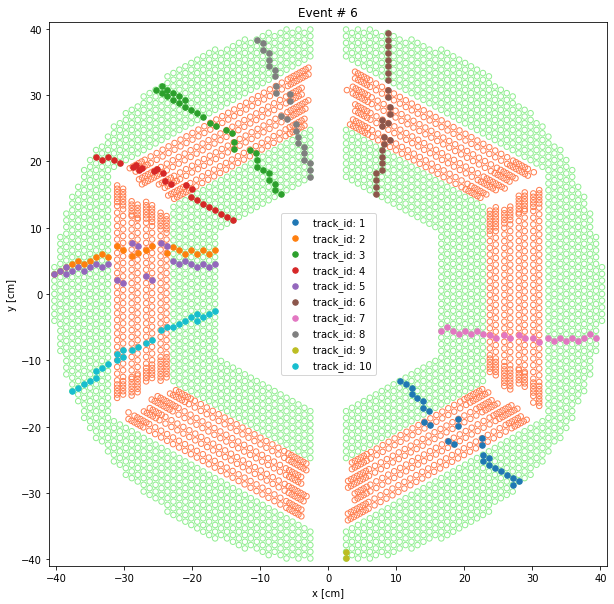

In [77]:
plot_single_event(hits, event_id)

In [73]:
tubes.head()

,hit_id,tube_id,skewed,layer_id,sector_id,isochrone,depcharge,energyloss
0,1,29,0,0,1,0.114209,9042780.0,9.04278
1,2,135,0,1,1,0.095118,9710870.0,9.71087
2,3,247,0,2,1,0.335250,6263420.0,6.26342
3,4,364,0,3,1,0.449369,1968350.0,1.96835
4,5,365,0,3,1,0.496048,2251290.0,2.25129


In [71]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,track_id
0,1,-16.5906,-2.61719,19.9457,-0.140571,-0.043377,0.171709,10
1,2,-17.5307,-2.91830,21.0973,-0.139694,-0.046391,0.171582,10
2,3,-18.4725,-3.24037,22.2546,-0.139290,-0.049329,0.171052,10
3,4,-19.0836,-3.46021,23.0046,-0.139190,-0.051512,0.170426,10
4,5,-19.4161,-3.58481,23.4123,-0.138798,-0.052697,0.170295,10


In [72]:
particles.head()

,track_id,vx,vy,vz,px,py,pz,q,pdg_code,start_time
0,10,0,0,0,-0.150929,-0.000336,0.180806,-1,13,0
1,10,0,0,0,-0.150929,-0.000336,0.180806,-1,13,0
2,10,0,0,0,-0.150929,-0.000336,0.180806,-1,13,0
3,10,0,0,0,-0.150929,-0.000336,0.180806,-1,13,0
4,10,0,0,0,-0.150929,-0.000336,0.180806,-1,13,0


In [10]:
# Preprocess Events
events = preprocess(evts)

event 100
event 200
event 300
event 400
event 500
event 600
event 700
event 800
event 900


In [11]:
# Alternate to Above is DASK (All Events)
# hits, truth = dask_events(path)

In [12]:
events[0].head()

,hit_id,x,y,skewed,layer_id,sector_id,isochrone,particle_id
0,89,16.6190,0.505,0,0,4,0.188493,14
1,90,17.4937,0.000,0,1,4,0.347103,14
2,91,18.3684,0.505,0,2,4,0.145716,14
3,92,19.2431,0.000,0,3,4,0.388572,14
4,93,20.1178,0.505,0,4,4,0.096961,14


## _Event Vizualization_

In [13]:
event_id = 2

<Figure size 432x288 with 0 Axes>

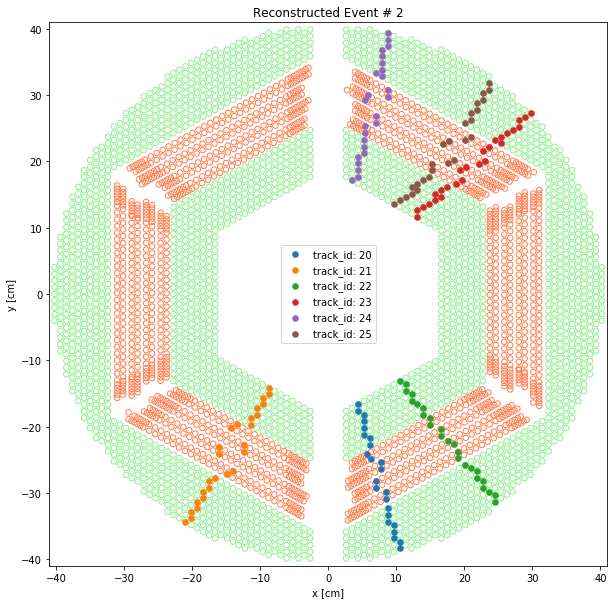

In [14]:
# Visualize Raw Event
draw_single_event(event=evts[event_id], event_id=event_id, name="event");

<Figure size 432x288 with 0 Axes>

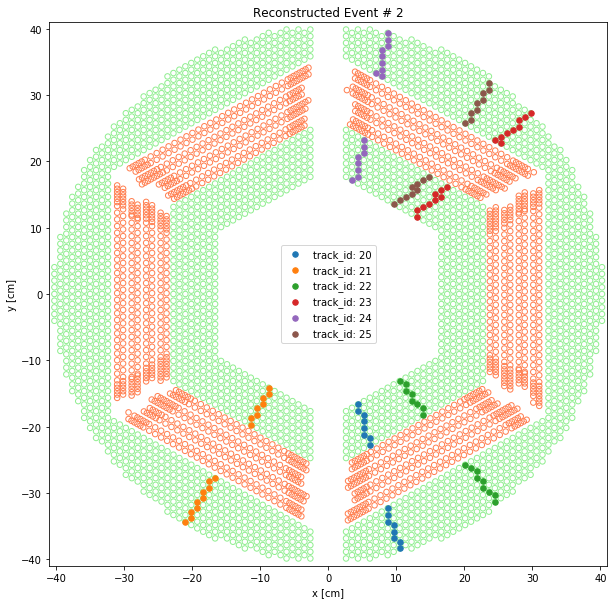

In [15]:
# Visualize Preprocessed Event
draw_single_event(event=events[event_id-1], event_id=event_id, name="event_inout");

## _Prepare Training Data_

Dataset for training (Hit Doublets)

In [16]:
%time
X, Y = prepare_train_set(events=events, n_events=1000)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


## _Train Model_

In [17]:
Train=False

In [18]:
if Train:
    # Build Model:
    model = init_model_dnn(shape=X.shape[1])
        
    # Model Summary
    model.summary()
    
    # Save Model as PNG
    plot_model(model, to_file='models/dnn_inout.png', show_shapes=True, show_layer_names=True)
    # SVG(model_to_dot(model).create(prog='dot', format='svg'))

W1010 15:51:45.341673 139695914989376 deprecation_wrapper.py:119] From /shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 15:51:45.377940 139695914989376 deprecation_wrapper.py:119] From /shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 15:51:45.394776 139695914989376 deprecation_wrapper.py:119] From /shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1010 15:51:45.443568 139695914989376 deprecation_wrapper.py:119] From /shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
__________

In [19]:
# ANNVisualizer
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True,  filename="dnn", title="Deep Neural Network")

if Train:
    # Fit the Model
    hist = model.fit_generator(generator=train_batcher, steps_per_epoch=epoch_size, epochs=num_epochs,
                               verbose=1, validation_data=valid_batcher, validation_steps=val_step, 
                               use_multiprocessing=False)

In [20]:
if Train:
    # Fit the Model
    hist = model.fit(X, Y, epochs=20, batch_size=batch_size, validation_split=val_frac, verbose=1)

Train on 5364628 samples, validate on 596070 samples
Epoch 1/20
5364628/5364628 [==============================] - 201s 37us/step - loss: 0.1667 - acc: 0.9280 - val_loss: 0.1368 - val_acc: 0.9475
Epoch 2/20
5364628/5364628 [==============================] - 224s 42us/step - loss: 0.1427 - acc: 0.9457 - val_loss: 0.1250 - val_acc: 0.9559
Epoch 3/20
5364628/5364628 [==============================] - 224s 42us/step - loss: 0.1376 - acc: 0.9493 - val_loss: 0.1229 - val_acc: 0.9569
Epoch 4/20
5364628/5364628 [==============================] - 225s 42us/step - loss: 0.1358 - acc: 0.9505 - val_loss: 0.1227 - val_acc: 0.9571
Epoch 5/20
5364628/5364628 [==============================] - 227s 42us/step - loss: 0.1352 - acc: 0.9509 - val_loss: 0.1216 - val_acc: 0.9582
Epoch 6/20
5364628/5364628 [==============================] - 227s 42us/step - loss: 0.1347 - acc: 0.9513 - val_loss: 0.1222 - val_acc: 0.9579
Epoch 7/20
5364628/5364628 [==============================] - 218s 41us/step - loss: 0.13

In [21]:
if Train:
    # Save the Model
    model.save('models/dnn_inout.h5')
    
    # Save History (Using Pickle)
    with open('models/dnn_inout.pickle', 'wb') as hist_file:
        pickle.dump(hist.history, hist_file)

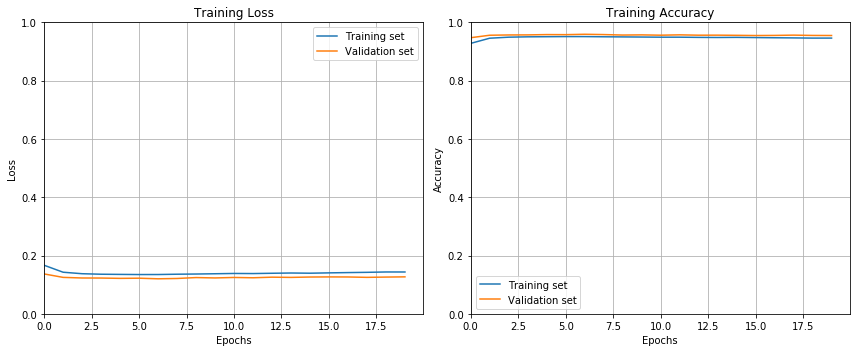

In [22]:
if Train:
    # Plot Train History
    draw_train_history(hist);

## _Load Model_

In [29]:
Load=True

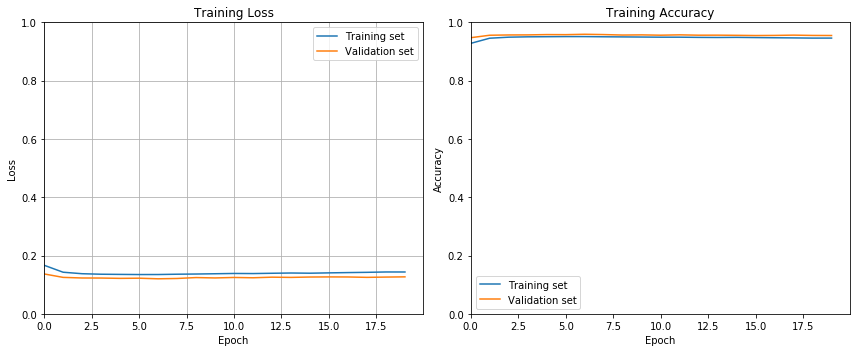

In [30]:
if Load:
    history = None
    with open('models/dnn_inout.pickle', 'rb') as pickle_in:
        history = pickle.load(pickle_in)
    draw_pickled_history(history, draw_val=True);

In [21]:
np.arange(1,len(history['loss'])+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

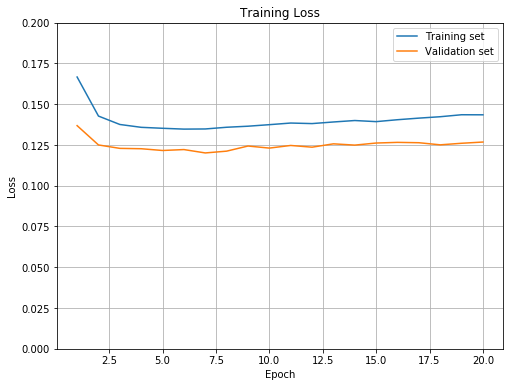

In [23]:
from matplotlib.ticker import MaxNLocator
draw_val = True
fig = plt.figure(figsize=(8, 6))

epochs = np.arange(1,len(history['loss'])+1)

# Plot training & validation accuracy values

plt.plot(epochs, history['loss'], label='Training set')
if draw_val:
    plt.plot(epochs, history['val_loss'], label='Validation set')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0., 0.2)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

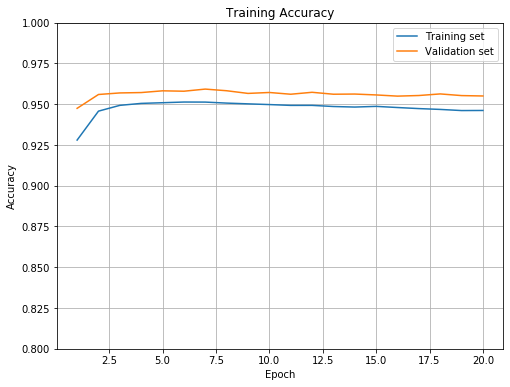

In [25]:
# Plot training & validation loss values
draw_val = True
fig = plt.figure(figsize=(8, 6))

epochs = np.arange(1,len(history['loss'])+1)

plt.plot(epochs, history['acc'], label='Training set')
if draw_val:
    plt.plot(epochs, history['val_acc'], label='Validation set')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.ylim(0.8, 1.0)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

In [28]:
# if Load:
    # model = load_model('models/init_model_dnn.h5')

## _Test Model_

*Accuracy/Classification:* `np.mean(y_pred == y_test)`
*Missclassification:* `np.mean(y_pred != y_test`

In [33]:
# See Model Metrics
# model.metrics_names

In [34]:
# test_set loss and accuracy
# test_loss, test_acc = model.evaluate(X_test, y_test)

In [35]:
# Print test_set loss and accuracy
# print("test_loss:", test_loss, ", test_acc:", test_acc)

## _Model Predictions_

*Prediction:* `y_pred = model.predict(X_test)`

In [36]:
# Get test set predictions
# y_pred = model.predict(X_test)
# y_pred.shape

## _SttHitClusterer_

In [8]:
class SttHitClusterer:
    def __init__(self, path, model=None, batch_size=128, num_epochs=10):
        
        # Build Model:
        self.model = model
        # self.model = build_model(self.hidden_dim, DetectorGeometry.layer_r.shape[0], self.num_phi_bin)
        # self.model = init_model_dnn(shape=10)
        
        # Params:
        self.path = path
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.val_frac = 0.2

        # Params:
        self.train_input = None
        self.train_target = None
        self.test_input = None
        self.test_pred = None
        
        # Params:
        self.history = None
        self.prepared = False
    
    def prepare_data(self, events, n_events):
        if self.prepared:
            return
        self.prepared = True
        self.train_input, train_target = prepare_pairs(events=events, n_events=n_events)
        
    def fit(self, events, n_events):
        
        # Prepare Data
        prepare_data(self, events, n_events)
        
        # Fit DNN Model
        self.history = self.model.fit(x=self.train_input,
                                      y=self.train_target,
                                      batch_size=self.batch_size,
                                      epochs=self.num_epochs,
                                      validation_split=self.val_frac)
        # Save the Model
        self.model.save("model.h5")
        
    def predict_single_event(self, x_event):
        print("TODO: predict single event")
        
    def param_summary(self):
        print("batch_size:", self.batch_size)
        print("num_epochs:", self.num_epochs)
        print("val. fraction:", self.val_frac)

In [10]:
clust = SttHitClusterer(path, model)

In [11]:
clust.param_summary()

batch_size: 128
num_epochs: 10
val. fraction: 0.2
